# DS3000 Lecture 13 and 14

### Admin: 
- Homework 7 posted on Thursday and due on Sunday
- Quiz 2 for the weekend

### Content:
- Classification and Regression
- Meaningful Distances and cross validation
- KNN 
- New module we need to use 'sklearn'

In [3]:
#pip install scikit-learn
import sklearn

## Organizing a data analysis project

What do we need to know about a data

- Introduction
  - Background (research question, why it is important or interesting)
  - Previous study
- Data
  - Source (where, do you collect it or scrap it aor find it) and format (csv or database or text)
  - Data size and features (numerical or categorical)
  - What is your target
  - EDA (make some data visualizations and interpret/guess the potential relationship between target and features)
- Model
    - Metrics
    - Model results
- Discussion
    - interpret the results
    - potential future works

## ML overview
|                          | Input Features per sample | Output Features per sample | Supervised | Penguin Example                                                                       |
|:------------------------:|:-------------------------:|:--------------------------:|:----------:|---------------------------------------------------------------------------------------|
|           Classification | 1+ numerical features     | one categorical feature    | True       | Given `body_weight_g`, `flipper_length_mm` estimate `species`                         |
|               Regression | 1+ numerical features     | one continuous feature     | True       | Given `body_weight_g`, `bill_depth_mm` estimate `flipper_length_mm`                   |
|               Clustering | 1+ numerical features     | one categorical feature    | False      | Identify k groups of penguins which have similar `body_weight_g`, `flipper_length_mm` |
| Dimensionality Reduction | N numerical features      | < N numerical features     | False      | Find 2d vector which best represents all 4 of penguin's body/flipper/beak features    |

## Classification

- How can I decide whether two observations are in the same group? - Similarity?
- Apply some models/algorithm
- How to evaluate my classificaiton? 

### Distances between samples
Many ML tools require that these vectors have meaningful distances between them.  
- A pair of samples with a large distance between them are considered different
- A pair of samples with a small distance between them are considered similar

Computing (the $\ell_2$, or Euclidean) distance between two vectors $x = \begin{bmatrix} x_1 \\ x_2 \end{bmatrix}$ and $x' = \begin{bmatrix} x_1' \\ x_2' \end{bmatrix}$:

$$||x - x'||_2 = \sqrt{\sum_i (x_i - x_i')^2}$$

In words, to compute the distance between two vectors:
- we square the differences of each element
- add these values together
- compute the square root of this sum

How similar is penguin0 to penguin1?

In [4]:
import seaborn as sns

df_penguins = sns.load_dataset('penguins')
penguin0 = df_penguins.iloc[0,:]
penguin0

species                 Adelie
island               Torgersen
bill_length_mm            39.1
bill_depth_mm             18.7
flipper_length_mm        181.0
body_mass_g             3750.0
sex                       Male
Name: 0, dtype: object

In [5]:
penguin1 = df_penguins.iloc[1,:]
penguin1

species                 Adelie
island               Torgersen
bill_length_mm            39.5
bill_depth_mm             17.4
flipper_length_mm        186.0
body_mass_g             3800.0
sex                     Female
Name: 1, dtype: object

In [6]:
((39.1-39.5)**2 + (18.7-17.4)**2 + (181 - 186)**2 + (3750 - 3800)**2)**0.5

50.26778292306117

In and of itself, this distance isn't too insightful ... the penguins are 50 ?unit? apart?  The value becomes more useful when compared to other distances.  Is penguin 1 more similar to penguin 0 or penguin 2?

In [7]:
import numpy as np 
import pandas as pd

df_penguins_num = df_penguins.iloc[:, 2:6]
df_penguins_num

vec_penguin0 = np.array(df_penguins_num.iloc[0, :])
vec_penguin1 = np.array(df_penguins_num.iloc[1, :])
vec_penguin2 = np.array(df_penguins_num.iloc[2, :])

l2_distance_0and1 = np.linalg.norm(vec_penguin0 - vec_penguin1)
l2_distance_1and2 = np.linalg.norm(vec_penguin1 - vec_penguin2)

print(f'distance between penguin0 and penguin 1 :{l2_distance_0and1:.3f}')
print(f'distance between penguin1 and penguin 2: {l2_distance_1and2:.3f}')

distance between penguin0 and penguin 1 :50.268
distance between penguin1 and penguin 2: 550.075


Yes, I do see 50 << 550. Can I make my conclusion penguin1 is more similar to penguin0 compare to penguin 2?

In [8]:
vec_penguin0 - vec_penguin1

array([ -0.4,   1.3,  -5. , -50. ])

In [9]:
vec_penguin1 - vec_penguin2

array([ -0.8,  -0.6,  -9. , 550. ])

## Big Idea 1: Distances assume that a change of 1 unit (in any feature) is equally significant

What if we measured the body mass of the penguin in a different unit?

In [10]:
# replace body_mass_g with body_mass_kg
df_penguins_num['body_mass_kg'] = df_penguins_num['body_mass_g']/1000
del df_penguins_num['body_mass_g']

df_penguins_num.head()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_kg
0,39.1,18.7,181.0,3.75
1,39.5,17.4,186.0,3.80
2,40.3,18.0,195.0,3.25
3,NaN,NaN,NaN,NaN
4,36.7,19.3,193.0,3.45


In [11]:
vec_penguin0 = np.array(df_penguins_num.iloc[0, :])
vec_penguin1 = np.array(df_penguins_num.iloc[1, :])
vec_penguin2 = np.array(df_penguins_num.iloc[2, :])

l2_distance_0and1 = np.linalg.norm(vec_penguin0 - vec_penguin1)
l2_distance_1and2 = np.linalg.norm(vec_penguin1 - vec_penguin2)

print(f'distance between penguin0 and penguin 1 :{l2_distance_0and1:.3f}')
print(f'distance between penguin1 and penguin 2: {l2_distance_1and2:.3f}')

distance between penguin0 and penguin 1 :5.182
distance between penguin1 and penguin 2: 9.072


- **Distances assume that a change of 1 unit (in any feature) is equally significant**
- **Distances implicitly weight how important each feature is relative to others according to its variance**
    - a feature with a higher variance is responsible for more of the distances
    
To wrap all the different features into a single distance we must say *something* about how important one feature is compared to another.  

In [12]:
df_penguins_num.std()

bill_length_mm        5.459584
bill_depth_mm         1.974793
flipper_length_mm    14.061714
body_mass_kg          0.801955
dtype: float64

### Scale Normalization:
How to scale your features so that they're equally important in our distance metric:

- standard scaling: for each value, minus the average and then divided by the std
- min-max scaling: for each value, minus the min and then divided by the max

In [13]:
df_penguins_num_scaled = pd.DataFrame()

for feat in df_penguins_num.columns:
    df_penguins_num_scaled[f'{feat}_scaled'] = df_penguins_num[feat] / df_penguins_num[feat].std()

df_penguins_num_scaled.head()

,bill_length_mm_scaled,bill_depth_mm_scaled,flipper_length_mm_scaled,body_mass_kg_scaled
0,7.161718,9.469346,12.871831,4.676076
1,7.234984,8.811049,13.227406,4.738423
2,7.381515,9.114879,13.867442,4.052599
3,NaN,NaN,NaN,NaN
4,6.722124,9.773175,13.725212,4.301990


In [14]:
df_penguins_num_scaled.std()

bill_length_mm_scaled       1.0
bill_depth_mm_scaled        1.0
flipper_length_mm_scaled    1.0
body_mass_kg_scaled         1.0
dtype: float64

In [15]:
df_penguins_num_scaled.columns = ['bill_length_scaled', 'bill_depth_scaled',
                                'flipper_length_scaled', 'body_mass_scaled']
df_penguins_num_scaled

,bill_length_scaled,bill_depth_scaled,flipper_length_scaled,body_mass_scaled
0,7.161718,9.469346,12.871831,4.676076
1,7.234984,8.811049,13.227406,4.738423
2,7.381515,9.114879,13.867442,4.052599
3,NaN,NaN,NaN,NaN
4,6.722124,9.773175,13.725212,4.301990
...,...,...,...,...
339,NaN,NaN,NaN,NaN
340,8.572082,7.241265,15.289744,6.047724
341,9.231473,7.950200,15.787549,7.169983
342,8.279019,7.494456,15.076399,6.484158


Or, a black box version, the more commonly used one: 

In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_penguins_num_scaled = scaler.fit_transform(df_penguins_num)

df_penguins_num_scaled = pd.DataFrame(df_penguins_num_scaled)

df_penguins_num_scaled.columns = ['bill_length_scaled', 'bill_depth_scaled',
                                'flipper_length_scaled', 'body_mass_scaled']
df_penguins_num_scaled.head()

,bill_length_scaled,bill_depth_scaled,flipper_length_scaled,body_mass_scaled
0,-0.884499,0.785449,-1.418347,-0.564142
1,-0.811126,0.126188,-1.062250,-0.501703
2,-0.664380,0.430462,-0.421277,-1.188532
3,NaN,NaN,NaN,NaN
4,-1.324737,1.089724,-0.563715,-0.938776


In [17]:
df_penguins_num_scaled.std()

bill_length_scaled       1.001465
bill_depth_scaled        1.001465
flipper_length_scaled    1.001465
body_mass_scaled         1.001465
dtype: float64

### Exercise 1

Quantitatively, which pair of the following apartments is most similar?

|       | sq ft | bedrooms | bathrooms | toilets |
|-------|------:|---------:|----------:|---------|
| apt 0 |   850 |        2 |         1 | 1       |
| apt 1 |  1000 |        2 |         2 | 2       |
| apt 2 |  1300 |        3 |         2 | 2       |

- Define and clearly explain how you quantify whether two apartments are similar or different
- Build a dataframe and explicilty compute each pair's distance
- Be warned, this example has a quirk we haven't yet seen in class.  You can resolve it yourself with some careful thinking, do what makes sense to you!

In [18]:
# solution
import pandas as pd

df_apt = pd.DataFrame({'sq ft': [850, 1000, 1300],
                       'bedrooms': [2, 2, 3],
                       'bathrooms': [1, 2, 2],
                       'toilets': [1, 2, 2]})
df_apt

,sq ft,bedrooms,bathrooms,toilets
0,850,2,1,1
1,1000,2,2,2
2,1300,3,2,2


In [19]:
df_apt.std()

sq ft        229.128785
bedrooms       0.577350
bathrooms      0.577350
toilets        0.577350
dtype: float64

In [20]:
for feat in df_apt.columns:
    df_apt[feat] = df_apt[feat]/df_apt[feat].std()

df_apt.std()

sq ft        1.0
bedrooms     1.0
bathrooms    1.0
toilets      1.0
dtype: float64

In [21]:
del df_apt['toilets']

In [22]:
dist01 = np.linalg.norm(np.array(df_apt.iloc[0,:] - df_apt.iloc[1,:]))
dist02 = np.linalg.norm(np.array(df_apt.iloc[0,:] - df_apt.iloc[2,:]))
dist12 = np.linalg.norm(np.array(df_apt.iloc[1,:] - df_apt.iloc[2,:]))

print(f'the distance between apt 0 and apt 1 is {dist01}')
print(f'the distance between apt 0 and apt 2 is {dist02}')
print(f'the distance between apt 1 and apt 2 is {dist12}')

the distance between apt 0 and apt 1 is 1.8516401995451033
the distance between apt 0 and apt 2 is 3.1396087108337016
the distance between apt 1 and apt 2 is 2.171240593367237


## One hot encoding and "Dummy" variables
### (Representing categorical variables in the sample vector as numbers)

**One hot encoding:** replace each categorical column with a set of columns per each unique category.  These new columns (called dummy variables) have value 1 where the original row belonged to the corresponding category.

In [23]:
df_penguin = sns.load_dataset('penguins')

# discard penguins with missing features
df_penguin.dropna(axis=0, inplace=True)

# shuffle order of rows
df_penguin = df_penguin.sample(frac=1, random_state=1)

# grab only the first few rows
df_penguin = df_penguin.head()

df_penguin

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
65,Adelie,Biscoe,41.6,18.0,192.0,3950.0,Male
276,Gentoo,Biscoe,43.8,13.9,208.0,4300.0,Female
186,Chinstrap,Dream,49.7,18.6,195.0,3600.0,Male
198,Chinstrap,Dream,50.1,17.9,190.0,3400.0,Female
293,Gentoo,Biscoe,46.5,14.8,217.0,5200.0,Female


In [24]:
pd.get_dummies(df_penguin, columns = ['species', 'island', 'sex'])

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,species_Adelie,species_Chinstrap,species_Gentoo,island_Biscoe,island_Dream,sex_Female,sex_Male
65,41.6,18.0,192.0,3950.0,True,False,False,True,False,False,True
276,43.8,13.9,208.0,4300.0,False,False,True,True,False,True,False
186,49.7,18.6,195.0,3600.0,False,True,False,False,True,False,True
198,50.1,17.9,190.0,3400.0,False,True,False,False,True,True,False
293,46.5,14.8,217.0,5200.0,False,False,True,True,False,True,False


## K-Nearest Neighbors Classifier

#### Goal:
Make a function which estimates `species` from `bill_depth_mm` and `bill_length_mm`.

#### Problem Statement (any classifier):

For an initial set of training penguins we observe:
- `bill_depth_mm`
- `bill_length_mm`
- `species` 

Given some new penguin, Gerald, who is not in the training set on which we observe:
- `bill_depth_mm`
- `bill_length_mm`

#### K-Nearest Neighbors (k-NN) Approach:
We identify the penguins which are the $k$ Nearest Neighbors (those whose bill depth/length have the smallest distances) of Gerald.  We estimate Gerald's species as the most common species of these $k$ Nearest Neighbors.

In [25]:
import seaborn as sns

df_penguin = sns.load_dataset('penguins')
df_penguin.dropna(axis=0, inplace=True)
df_penguin.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male


In [26]:
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd

feat0 = 'bill_depth_mm'
feat1 = 'bill_length_mm'

sns.set(font_scale=1.2)

# add Gerald to the dataframe
Gerald = {'species': 'Unknown? (Gerald)', 
          'bill_depth_mm': 17.42, 
          'bill_length_mm': 42.5}
df_penguin_gerald = pd.concat([df_penguin, pd.Series(Gerald).to_frame().T])

px.scatter(data_frame=df_penguin_gerald, x=feat0, y=feat1, color='species')

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'hovertemplate': 'species=Adelie<br>bill_depth_mm=%{x}<br>bill_length_mm=%{y}<extra></extra>',
              'legendgroup': 'Adelie',
              'marker': {'color': '#636efa', 'symbol': 'circle'},
              'mode': 'markers',
              'name': 'Adelie',
              'orientation': 'v',
              'showlegend': True,
              'type': 'scatter',
              'x': array([18.7, 17.4, 18.0, 19.3, 20.6, 17.8, 19.6, 17.6, 21.2, 21.1, 17.8, 19.0,
                          20.7, 18.4, 21.5, 18.3, 18.7, 19.2, 18.1, 17.2, 18.9, 18.6, 17.9, 18.6,
                          18.9, 16.7, 18.1, 17.8, 18.9, 17.0, 21.1, 20.0, 18.5, 19.3, 19.1, 18.0,
                          18.4, 18.5, 19.7, 16.9, 18.8, 19.0, 17.9, 21.2, 17.7, 18.9, 17.9, 19.5,
                          18.1, 18.6, 17.5, 18.8, 16.6, 19.1, 16.9, 21.1, 17.0, 18.2, 17.1, 18.0,
                          16.2, 19.1, 16.6, 19.4, 19.0, 18.4, 17.2, 18.9, 17.5, 18.5, 16.8, 19.4,
                          16.1, 19.1, 17.2, 17.6, 18.8, 19.4, 17.8, 20.3, 19.5, 18.6, 19.2, 18.8,
                          18.0, 18.1, 17.1, 18.1, 17.3, 18.9, 18.6, 18.5, 16.1, 18.5, 17.9, 20.0,
                          16.0, 20.0, 18.6, 18.9, 17.2, 20.0, 17.0, 19.0, 16.5, 20.3, 17.7, 19.5,
                          20.7, 18.3, 17.0, 20.5, 17.0, 18.6, 17.2, 19.8, 17.0, 18.5, 15.9, 19.0,
                          17.6, 18.3, 17.1, 18.0, 17.9, 19.2, 18.5, 18.5, 17.6, 17.5, 17.5, 20.1,
                          16.5, 17.9, 17.1, 17.2, 15.5, 17.0, 16.8, 18.7, 18.6, 18.4, 17.8, 18.1,
                          17.1, 18.5], dtype=object),
              'xaxis': 'x',
              'y': array([39.1, 39.5, 40.3, 36.7, 39.3, 38.9, 39.2, 41.1, 38.6, 34.6, 36.6, 38.7,
                          42.5, 34.4, 46.0, 37.8, 37.7, 35.9, 38.2, 38.8, 35.3, 40.6, 40.5, 37.9,
                          40.5, 39.5, 37.2, 39.5, 40.9, 36.4, 39.2, 38.8, 42.2, 37.6, 39.8, 36.5,
                          40.8, 36.0, 44.1, 37.0, 39.6, 41.1, 36.0, 42.3, 39.6, 40.1, 35.0, 42.0,
                          34.5, 41.4, 39.0, 40.6, 36.5, 37.6, 35.7, 41.3, 37.6, 41.1, 36.4, 41.6,
                          35.5, 41.1, 35.9, 41.8, 33.5, 39.7, 39.6, 45.8, 35.5, 42.8, 40.9, 37.2,
                          36.2, 42.1, 34.6, 42.9, 36.7, 35.1, 37.3, 41.3, 36.3, 36.9, 38.3, 38.9,
                          35.7, 41.1, 34.0, 39.6, 36.2, 40.8, 38.1, 40.3, 33.1, 43.2, 35.0, 41.0,
                          37.7, 37.8, 37.9, 39.7, 38.6, 38.2, 38.1, 43.2, 38.1, 45.6, 39.7, 42.2,
                          39.6, 42.7, 38.6, 37.3, 35.7, 41.1, 36.2, 37.7, 40.2, 41.4, 35.2, 40.6,
                          38.8, 41.5, 39.0, 44.1, 38.5, 43.1, 36.8, 37.5, 38.1, 41.1, 35.6, 40.2,
                          37.0, 39.7, 40.2, 40.6, 32.1, 40.7, 37.3, 39.0, 39.2, 36.6, 36.0, 37.8,
                          36.0, 41.5], dtype=object),
              'yaxis': 'y'},
             {'hovertemplate': 'species=Chinstrap<br>bill_depth_mm=%{x}<br>bill_length_mm=%{y}<extra></extra>',
              'legendgroup': 'Chinstrap',
              'marker': {'color': '#EF553B', 'symbol': 'circle'},
              'mode': 'markers',
              'name': 'Chinstrap',
              'orientation': 'v',
              'showlegend': True,
              'type': 'scatter',
              'x': array([17.9, 19.5, 19.2, 18.7, 19.8, 17.8, 18.2, 18.2, 18.9, 19.9, 17.8, 20.3,
                          17.3, 18.1, 17.1, 19.6, 20.0, 17.8, 18.6, 18.2, 17.3, 17.5, 16.6, 19.4,
                          17.9, 19.0, 18.4, 19.0, 17.8, 20.0, 16.6, 20.8, 16.7, 18.8, 18.6, 16.8,
                          18.3, 20.7, 16.6, 19.9, 19.5, 17.5, 19.1, 17.0, 17.9, 18.5, 17.9, 19.6,
                          18.7, 17.3, 16.4, 19.0, 17.3, 19.7, 17.3, 18.8, 16.6, 19.9, 18.8, 19.4,
                          19.5, 16.5, 17.0, 19.8, 18.1, 18.2, 19.0, 18.7], dtype=object),
              'xaxis': 'x',
              'y': array([46.5, 50.0, 51.3, 45.4, 52.7, 45.2, 46.1, 51.3, 46.0, 51.3, 46.6, 51.7,

If K = 3, Gerald's K Nearest Neighbors are:
- Chinstrap
- Chinstrap
- Adelie

So we'd estimate Gerald is of species Chinstrap (most common Nearest Neighbor species)

If K = 5, Gerald's K Nearest Neighbors are:
- Chinstrap
- chinstrap
- Adelie
- Adelie
- Adelie

So we'd estimate Gerald is of species Adelie (most common Nearest Neighbor species)

If K=4, Gerald's K Nearest Neighbors are:
- Chinstrap
- chinstrap
- Adelie
- Adelie

So we could either:
- avoid outputting an estimate
- discard furthest neighbor among k Nearest Neighbors
    - estimate "recursively" using K-1 Nearest Neighbors

## K-Nearest Neighbors Demo

http://vision.stanford.edu/teaching/cs231n-demos/knn/

## K-NN Classifier: prepping input sci-kit learn

Scikit Learn operates on arrays.  We must construct two arrays:
- x
    - input feature matrix (the features we use to define distances)
        - each row is a sample (e.g. penguin)
        - each column is a numeric feature (e.g. bill depth/length)
- y
    - target variable vector
        - vector length = number of samples (e.g. penguins)
        - value is categorical feature (e.g. species)
            - can use array of strings (we do here) ... ok for this application but in general: prefer list of strings

In [27]:
import numpy as np

x_feat_list = ['bill_length_mm', 'bill_depth_mm']
x = df_penguin.loc[:, x_feat_list].values

x[:5,:]

array([[39.1, 18.7],
       [39.5, 17.4],
       [40.3, 18. ],
       [36.7, 19.3],
       [39.3, 20.6]])

In [28]:
df_penguin.loc[:, x_feat_list]

,bill_length_mm,bill_depth_mm
0,39.1,18.7
1,39.5,17.4
2,40.3,18.0
4,36.7,19.3
5,39.3,20.6
...,...,...
338,47.2,13.7
340,46.8,14.3
341,50.4,15.7
342,45.2,14.8


In [29]:
y_true = df_penguin.loc[:, 'species'].values
y_true[:5]

array(['Adelie', 'Adelie', 'Adelie', 'Adelie', 'Adelie'], dtype=object)

## K-NN Classifier: sci-kit learn & confusion matrix

In [30]:
from sklearn.neighbors import KNeighborsClassifier

k = 3
x_feat_list = ['bill_length_mm', 'bill_depth_mm']
x = df_penguin.loc[:, x_feat_list].values
y_true = df_penguin.loc[:, 'species'].values

# define the function/model
knn_classifier = KNeighborsClassifier(n_neighbors = k)

# fit the model
knn_classifier.fit(x, y_true)

# predict with the model
y_pred = knn_classifier.predict(x)

In [31]:
true_pred_list = list(zip(y_true, y_pred))
true_pred_list[:5]

[('Adelie', 'Adelie'),
 ('Adelie', 'Adelie'),
 ('Adelie', 'Adelie'),
 ('Adelie', 'Adelie'),
 ('Adelie', 'Adelie')]

In [32]:
from collections import Counter
Counter(true_pred_list)

Counter({('Adelie', 'Adelie'): 144,
         ('Gentoo', 'Gentoo'): 117,
         ('Chinstrap', 'Chinstrap'): 64,
         ('Adelie', 'Chinstrap'): 2,
         ('Chinstrap', 'Gentoo'): 2,
         ('Chinstrap', 'Adelie'): 2,
         ('Gentoo', 'Adelie'): 1,
         ('Gentoo', 'Chinstrap'): 1})

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

conf_mat = confusion_matrix(y_true = y_true, y_pred = y_pred)
conf_mat

array([[144,   2,   0],
       [  2,  64,   2],
       [  1,   1, 117]])

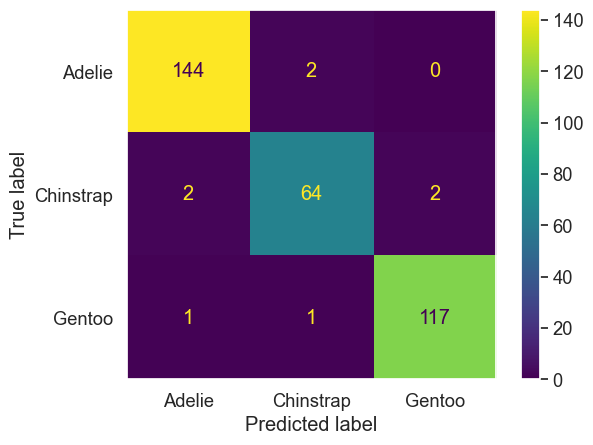

In [34]:
conf_mat_disp = ConfusionMatrixDisplay(conf_mat, display_labels = np.unique(y_true))
conf_mat_disp.plot()
plt.grid(False)

# How to check the accuracy of predictions?

There are several ways, but one is to look at the proportion of each label that are correctly predicted, and also check to see what the most common mistaken label is:

### Exercise 2

Build a K-NN classifier which estimates the `maintype` of Grass, Water, and Fire Pokemon given their `height`, `weight` and `damage` features.
- Discard any Pokemon who are not one of the three types
- Don't forget to do the scale normalization
- Show the output of your classification as a confusion matrix plot, as shown above
- Calculate the accuracy of the predictions for your classifier

In [35]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import matplotlib.pyplot as plt

sns.set(font_scale=1.2)

def make_lower(x):
    return str(x).lower()

df_poke = pd.read_csv('pokedata.csv')
df_poke = df_poke.rename(make_lower, axis = 1)
df_poke = df_poke.set_index('pokedex')

df_poke.head()

FileNotFoundError: [Errno 2] No such file or directory: 'pokedata.csv'

## Measuring Classification Performance

- cross validation
- performance measures

### Part 1 Cross Validation

Let's see what happens when we use $k =1$ to estimate a penguins `species` by observing its `bill_depth_mm` and `bill_length_mm`:

In [ ]:
import pandas as pd
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

df_penguin = sns.load_dataset('penguins')
df_penguin.dropna(how='any', inplace=True)

In [ ]:
k = 1
x_feat_list = ['bill_depth_mm', 'bill_length_mm']
y_feat = 'species'

x = df_penguin.loc[:, x_feat_list].values
y_true = df_penguin.loc[:, y_feat].values

# initialize a knn_classifier
knn_classifier = KNeighborsClassifier(n_neighbors=k)

# fit happens "inplace", we modify the internal state of knn_classifier to remember all the training samples
knn_classifier.fit(x, y_true)

# estimate each penguin's species
y_pred = knn_classifier.predict(x)

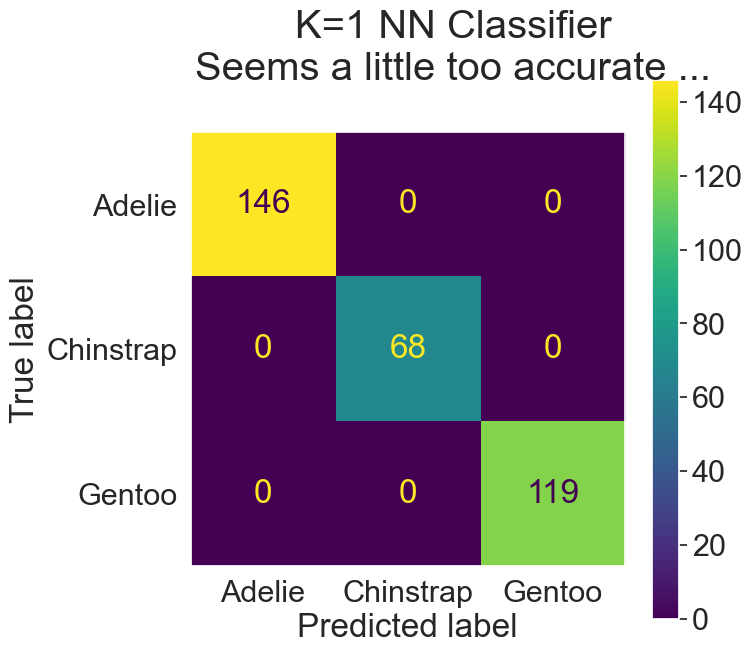

In [ ]:
conf_mat = confusion_matrix(y_true=y_true, y_pred=y_pred)
conf_mat_disp = ConfusionMatrixDisplay(conf_mat, display_labels=np.unique(y_true))

sns.set(font_scale=2)
conf_mat_disp.plot()
plt.suptitle('K=1 NN Classifier\nSeems a little too accurate ...')
plt.gcf().set_size_inches(7, 7)
plt.grid(False)

What happened? Does this confusion matrix accurately represent the performance of the classifier on new penguins?  Why or why not?  How might you fix this issue?

## Cross Validation

Remember, we want to know how well our classifier predicts the species of a Penguin it **hasn't** yet seen:
- This `k=1` nearest neighbor classifier finds the penguin which is closest, training on all the penguins before classifying the very same penguins
    - it does well because each penguin is its own nearest neighbor!
- Remember Gerald the penguin?  That was a fair comparison because our "classifier" was not trained using Gerald's data
   

**To approximate the performance of a classifier on new samples, we must measure its performance on samples it hasn't been trained on**

### K-Fold Cross Validation (this is a different K)

1. Partition the data into K distinct "folds"
    - "fold" - a subset of the labelled data
1. For each fold i
    - train the model on all but the i-th fold
    - test the model on the i-th fold
    
   
<img src="https://i.ibb.co/rHz3GMH/Screenshot-2024-07-22-221112.png" alt="Screenshot-2024-07-22-221112" border="0" width = 500px>

Animated:

http://assets.yihui.org/figures/animation/example/cv-ani/demo-a.mp4

In [ ]:
from sklearn.model_selection import KFold
import pandas as pd

df_beatles = pd.DataFrame({'name': ['john', 'ringo', 'paul', 'george'],
                          'favorite number': [0, 2, 104, -5],
                          'letters in name': [4, 5, 4, 6],
                          'takes milk in coffee': [True, True, False, False]})
df_beatles

,name,favorite number,letters in name,takes milk in coffee
0,john,0,4,True
1,ringo,2,5,True
2,paul,104,4,False
3,george,-5,6,False


Using the `favorite number` and `letters in name` to predict which of the beatles `takes milk in coffee`:

## Applying Cross Validation to our penguins species classification...
### First, some useful tools:

Let's see how this works; K-Fold (with $K = 3$) Cross Validation of k-Nearest Neighbors (with $k = 1$) in our Penguin dataset:

In [ ]:
k = 1
x_feat_list = ['bill_depth_mm', 'bill_length_mm']
y_feat = 'species'

x = df_penguin.loc[:, x_feat_list].values
y_true = df_penguin.loc[:, y_feat].values

# initialize a knn_classifier
knn_classifier = KNeighborsClassifier(n_neighbors=k)

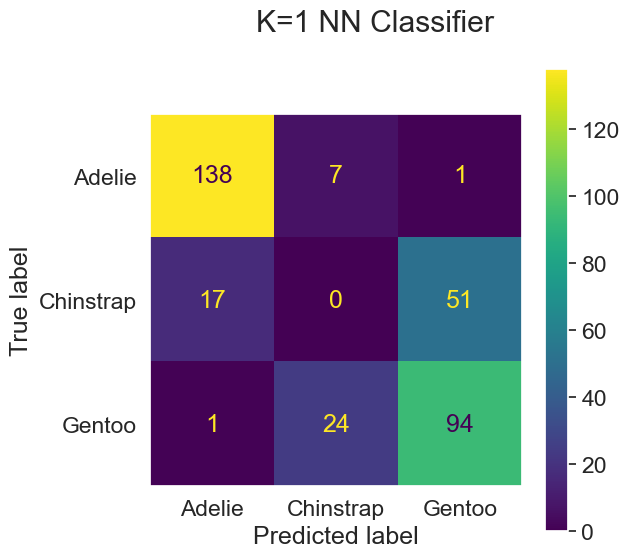

In [ ]:
# build and plot confusion matrix
conf_mat = confusion_matrix(y_true=y_true, y_pred=y_pred)
conf_mat_disp = ConfusionMatrixDisplay(conf_mat, display_labels=np.unique(y_true))

sns.set(font_scale=1.5)
conf_mat_disp.plot()
plt.suptitle('K=1 NN Classifier')
plt.gcf().set_size_inches(6, 6)
plt.grid(False)

## There's something funny about our confusion matrix ...

Why are none of the Chinstrap predicted correctly...? lets count the `species` in each set of training data.

In [ ]:
from copy import copy
from collections import Counter

k = 1
x_feat_list = ['bill_depth_mm', 'bill_length_mm']
y_feat = 'species'

x = df_penguin.loc[:, x_feat_list].values
y_true = df_penguin.loc[:, y_feat].values

# initialize a knn_classifier
knn_classifier = KNeighborsClassifier(n_neighbors=k)

# construction of kfold object
kfold = KFold(n_splits=3)

# allocate an empty array to store predictions in
y_pred = copy(y_true)

for train_idx, test_idx in kfold.split(x, y_true):
    # build arrays which correspond to x, y train /test
    x_test = x[test_idx, :]
    x_train = x[train_idx, :]
    y_true_train = y_true[train_idx]
    
    print(Counter(y_true_train))
    
    # fit happens "inplace", we modify the internal state of knn_classifier to remember all the training samples
    knn_classifier.fit(x_train, y_true_train)

    # estimate each penguin's species
    y_pred[test_idx] = knn_classifier.predict(x_test)

Counter({'Gentoo': 119, 'Chinstrap': 68, 'Adelie': 35})
Counter({'Adelie': 111, 'Gentoo': 111})
Counter({'Adelie': 146, 'Chinstrap': 68, 'Gentoo': 8})


Notice that we don't always get a proper mix of species in each training set ... the second training set doesn't even have any Chinstrap penguins!

Why is this?

## Ensuring that each training set represents all target groups:

- we can pass the `shuffle=True` parameter to the constructor of `Kfold` so that data is shuffled before the training indexing

- alternatively, we could use a `StratifiedKFold` object in place of a plain old `Kfold`:


     "This cross-validation object is a variation of KFold that returns stratified folds. The folds are made by 
     preserving the percentage of samples for each class."  
     
taken from [sklearn doc](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold)

using `shuffle=True` on a `KFold`

In [ ]:
from copy import copy
from collections import Counter

k = 1
x_feat_list = ['bill_depth_mm', 'bill_length_mm']
y_feat = 'species'

x = df_penguin.loc[:, x_feat_list].values
y_true = df_penguin.loc[:, y_feat].values

# initialize a knn_classifier
knn_classifier = KNeighborsClassifier(n_neighbors=k)



using `StratifiedKFold`

In [ ]:
from copy import copy
from collections import Counter

k = 1
x_feat_list = ['bill_depth_mm', 'bill_length_mm']
y_feat = 'species'

x = df_penguin.loc[:, x_feat_list].values
y_true = df_penguin.loc[:, y_feat].values

# initialize a knn_classifier
knn_classifier = KNeighborsClassifier(n_neighbors=k)


`StratifiedKFold` is probably preferred, since it gets us as close as possible to an even splitting of target groups, but there is usually not much difference.

## Note this quirk:
the resulting `y_pred` contains predictions for all the samples ...

... but samples in different folds were estimated by classifiers trained on different data

### So which of these trained classifiers should we use as our "final" classifier?

None of them, better to re-train on the whole dataset.

### The point of cross validation:

- Have a better understanding of the performance of the K-NN classifier by pretending some of the data you have is new.

### The point of training the entire dataset:

- Make a K-NN classifier that you can fit to truly new data.

### Exercise 3

Build a 4-fold cross validated K-NN classifier which estimates the `maintype` of Grass, Water, and Fire Pokemon given their `height`, `weight` and `damage` features. Use nearest neighbors $k=3$.
- Discard any Pokemon who are not one of the three types
- Don't forget to do the scale normalization
- Enact the 5-fold cross validation
- Show the output of your classification as a confusion matrix plot, as shown above
- Calculate the overall accuracy **haven't done this yet**

In [ ]:
# read in Pokemon data again
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set(font_scale=1.2)

def make_lower(x):
    return str(x).lower()

df_poke = pd.read_csv('pokedata.csv')
df_poke = df_poke.rename(make_lower, axis = 1)
df_poke = df_poke.set_index('pokedex')
df_poke.head()

,pokemon,maintype,secondarytype,height,weight,damage,basespeed,attack,defense
pokedex,,,,,,,,,
1,Bulbasaur,Grass,Poison,24,25.2,45,45,49,49
2,Ivysaur,Grass,Poison,39,28.7,60,60,62,63
3,Venusaur,Grass,Poison,79,220.5,80,80,82,83
4,Charmander,Fire,NaN,24,18.7,39,65,52,43
5,Charmeleon,Fire,NaN,43,41.9,58,80,64,58


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd

## Overall Accuracy Score

## "This Classifier is 90% accurate"

... is that a good thing?

Lets take a look at a few 90% accurate classifications and see for ourselves:

 ## This classifier is 90% accurate: example 1
 <img src="https://i.ibb.co/z6VTVXV/accuracy-is-vague1.png" alt="title" >

 ## This classifier is 90% accurate: example 2
<img src="https://i.ibb.co/hD6QRKc/Screenshot-2024-07-22-225127.png" alt="Screenshot-2024-07-22-225127" border="0" width = 600px>

 ## This classifier is 90% accurate: example 3
 <img src="https://i.ibb.co/dMwVtKD/accuracy-is-vague3.png" alt="title" >

 ## This classifier is 90% accurate: example 4
 <img src="https://i.ibb.co/qD8B48v/accuracy-is-vague4.png" alt="title" >

 ## This classifier is 90% accurate: example 5
 <img src="https://i.ibb.co/W336XhF/accuracy-is-vague5.png" alt="title" >


## What about our confusion matrices?

<img src='https://i.ibb.co/YkNcR9P/conf-mat-penguin-knn.png' width=500px>

**Confusion Matrices, being a whole array of numbers, are not easily compared for sorting.**

(We'll focus on these scalar summary stats of accuracy today)**

# Inconsistent Naming Conventions Ahead:

https://en.wikipedia.org/wiki/Sensitivity_and_specificity

Everyone uses these ideas and each field seems to have their own terms of interest.

I'm sorry, its [a tough problem to fix](https://xkcd.com/927/) :)

## Binary classification: Names

Lets examine the binary classification problem, where we're trying to determine if a sample if of class 0 or class 1.

|                | Predict: Class 0 | Predict: Class1 |
|----------------|-------------------|------------------|
| Truth: Class 0 | True Negative (TN)     | False Positive (FP)   |
| Truth: Class 1 | False Negative (FN)    | True Positive (TP)    |

## Binary classification: Illness detection example

Example: Illness Detection
- Class 0: Healthy
- Class 1: Illness

(we reserve class 1 as the class of "x" in all "x" Detection problems)

|                    | Predict: Healthy (0)          | Predict: Illness (1)      |
|--------------------|-------------------------------|---------------------------|
| Truth: Healthy (0) |  |  |
| Truth: Illness (1) |    |     |

## How to describe binary classifier performance

- Accuracy
    - percentage of samples that the prediction is correct
    - illness detection example:
        - If 100 people take this test, how often will our test be correct?
$$ \rm{Accuracy} = \frac{\rm{TP} + \rm{TN}}{\rm{TP} + \rm{TN} + \rm{FP} + \rm{FN}} $$

- Sensitivity/Recall
    - percentage of class 1 samples which are predicted as class 1
    - illness detection example:
        - If 100 ill people take this test, how many will we detect as ill?
$$ \rm{Sensitivity} = \frac{\rm{TP}}{\rm{TP} + \rm{FN}} $$

- Specificity
    - percentage of samples predicted as class 1 which are truly class 1
    - illness detection example:
        - If the test says 100 people are ill, how many of these are really ill?
        
$$ \rm{Specificity} = \frac{\rm{TP}}{\rm{TP} + \rm{FP}} $$

In [39]:
from sklearn.metrics import confusion_matrix

def get_acc_sens_spec(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    return accuracy, sensitivity, specificity

## Example:

Let's build a K-NN classifier for whether a student has done their `co-op` based on their `prog_exp`, `age`, and `start_sal`, then examine it's accuracy, sensitivity and specificity.

In [37]:
# read in the final, clean data set
df_gtky = pd.read_csv('final_gtky.csv', index_col='student_id')
df_gtky.dropna(how='any', inplace=True)
df_gtky.head()

,class,co-op,prog_exp,age,start_sal,datetimestamp,python,java,r,c/c++,other(s)
student_id,,,,,,,,,,,
7289,Sophomore,False,9,234.0,60.0,2022-09-09 15:37:00,True,False,False,False,True
36,Sophomore,False,7,233.0,100.0,2022-09-09 16:01:00,True,False,False,False,False
2676,Junior,True,7,252.0,70.0,2022-09-09 14:19:00,True,True,False,True,False
3848,Junior,False,7,243.0,50.0,2022-09-09 16:07:00,True,True,False,False,False
2755,Sophomore,False,5,231.0,90.0,2022-09-09 16:06:00,True,False,True,False,False


In [38]:
# selects the features and target
X = df_gtky[['prog_exp', 'age', 'start_sal']]
y = df_gtky['co-op']

# build the classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X, y)

# predict part
y_pred = knn.predict(X)

# gets the accuracy, sensitivity, and specificity
accuracy, sensitivity, specificity = get_acc_sens_spec(y, y_pred)

# Output the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")

Accuracy: 0.9200
Sensitivity: 0.9000
Specificity: 0.9333
